***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Vanilla Helmholtz Machine -- Train with Perturbation


*Updated:* Feb 8, 2025


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import torch
torch.cuda.is_available()

True

In [3]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [4]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [5]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [6]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [7]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -100) # replace log(0) with -100
    return q

In [8]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [9]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [10]:
def layer_wise_train(input_x,param_xy,param_yx,lr,perturb):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    if perturb == True:
        output_y = (output_y + (torch.rand(output_y.size(),device=dev) < 1/4).long()).fmod(2)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [11]:
def wake_phase(Phi,Theta,data,lr,dev,perturb):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [12]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,perturb=False)
        input_x = output_y
    return Phi, Loss

In [13]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.to('cpu').numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [14]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [15]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [16]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [17]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [18]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [19]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [20]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [21]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

In [22]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

## Model

In [23]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [24]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [25]:
n_layer = len(n_dz)
n_layer

6

In [26]:
n_d = n_dz[0]
n_d

tensor(12)

In [27]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [28]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [29]:
Phi,Theta = para_init(n_dz)
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [30]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [31]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011])

In [32]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785])

In [33]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Recog_D_KL_Layer_0')
for i in range(n_layer-1):
    if i > 0:
        col_list.append('Recog_H_Layer_'+str(i))
        col_list.append('Recog_I_Layer_'+str(i))
        col_list.append('Recog_D_KL_Layer_'+str(i))
    col_list.append('Gen_H_Layer_'+str(i))
    col_list.append('Gen_I_Layer_'+str(i))
    col_list.append('Gen_D_KL_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Recog_D_KL_Layer_0',
 'Gen_H_Layer_0',
 'Gen_I_Layer_0',
 'Gen_D_KL_Layer_0',
 'Recog_H_Layer_1',
 'Recog_I_Layer_1',
 'Recog_D_KL_Layer_1',
 'Gen_H_Layer_1',
 'Gen_I_Layer_1',
 'Gen_D_KL_Layer_1',
 'Recog_H_Layer_2',
 'Recog_I_Layer_2',
 'Recog_D_KL_Layer_2',
 'Gen_H_Layer_2',
 'Gen_I_Layer_2',
 'Gen_D_KL_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_3',
 'Recog_D_KL_Layer_3',
 'Gen_H_Layer_3',
 'Gen_I_Layer_3',
 'Gen_D_KL_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_4',
 'Recog_D_KL_Layer_4',
 'Gen_H_Layer_4',
 'Gen_I_Layer_4',
 'Gen_D_KL_Layer_4']

In [34]:
len(col_list)

37

### 1. Online Training with Perturbation

In [33]:
# Analytic_ws_online_perturb = pd.DataFrame(columns=col_list)
# Analytic_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4


In [34]:
# Phi,Theta = para_init(n_dz)

In [33]:
Analytic_ws_online_perturb = pd.read_csv('Analytic_ws_online.csv', sep=",")
Analytic_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.549195,0.605361,0.602305,0.605072,0.622563,0.540904,0.589824,0.603657,0.627713,33.296188,...,0.046197,3.328649,0.137107,0.047209,1.656294,0.102774,0.010586,1.736177,0.0,0.010757
1,0.247130,0.140485,0.292811,0.228170,0.548773,0.328138,0.153250,0.300363,0.230656,15.386729,...,0.084750,1.721815,0.047009,0.090461,0.792900,0.026537,0.011451,0.787525,0.0,0.011612
2,0.208765,0.116884,0.190964,0.283248,0.515566,0.302988,0.132794,0.193816,0.335078,18.560917,...,0.029509,1.197296,0.084558,0.024726,0.805184,0.086434,0.005094,0.856439,0.0,0.004323
3,0.120577,0.086833,0.097020,0.084723,0.531883,0.222154,0.089573,0.106127,0.078722,19.667295,...,0.004319,0.497071,0.009731,0.004320,0.214638,0.007132,0.008732,0.252172,0.0,0.007822
4,0.107413,0.130565,0.081919,0.069047,0.520346,0.206933,0.144428,0.087216,0.078608,16.237511,...,0.003753,0.428099,0.009530,0.003350,0.177438,0.005935,0.004644,0.228993,0.0,0.003835
5,0.101646,0.032995,0.053908,0.032856,0.510918,0.215687,0.038783,0.057947,0.042218,13.548240,...,0.007187,0.364175,0.008009,0.008258,0.108021,0.008744,0.001545,0.138457,0.0,0.001326
6,0.092104,0.099257,0.054447,0.055602,0.492241,0.214647,0.109513,0.054261,0.065820,14.606894,...,0.001929,0.337383,0.019650,0.002198,0.286259,0.017637,0.005816,0.220555,0.0,0.006651
7,0.104955,0.114775,0.035502,0.028181,0.509704,0.189365,0.147709,0.029464,0.025966,17.366673,...,0.002556,0.187986,0.004411,0.003187,0.079605,0.002338,0.000078,0.081348,0.0,0.000076
8,0.085574,0.017484,0.034972,0.057759,0.489629,0.226097,0.026754,0.029619,0.035682,11.673016,...,0.000737,0.207102,0.005685,0.000788,0.141413,0.003798,0.001790,0.108292,0.0,0.002123
9,0.102654,0.016744,0.046859,0.113483,0.489840,0.236361,0.016777,0.046169,0.106179,9.151857,...,0.005596,0.278613,0.012660,0.005498,0.436774,0.006925,0.006474,0.345623,0.0,0.007283


In [44]:
para = np.load('Parameters_ws_online_perturb.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [81]:
batch_size = 1
lr = 0.1
epoch = 400

In [82]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=True)
        else:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=False)
        
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e % 10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        wake_ct = {}
        sleep_ct = {}
        wake_ct['Layer 0: dist'] = data_dist
        dist_ct_pre_s = torch.ones(1,device=dev)
        dist_ct_pre_w = data_dist
        for i in range(n_layer-1):
            prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
            sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
            sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
            dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

            if i < n_layer-2:
                prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
                wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
                wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
                dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
        for i in range(n_layer-1):
            dist_w = wake_ct['Layer '+str(i)+': dist']
            dist_s = sleep_ct['Layer '+str(i)+': dist']
            if i == 0:
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            if i > 0:
                H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
                stat.append(H_Y_w)
                H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
                I_w = H_Y_w - H_YX_w
                stat.append(I_w)
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
            stat.append(H_Y_s)
            H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
            I_s = H_Y_s - H_YX_s
            stat.append(I_s)
            D_KL_s = KL_divergence(dist_w,dist_s).item()
            stat.append(D_KL_s)
        Analytic_ws_online_perturb.loc[len(Analytic_ws_online_perturb)] = stat

Loss_wake: tensor([0.0000, 0.5135, 0.5378, 0.5822, 0.6100])     Loss_sleep: tensor([0.4967, 0.5968, 0.5722, 0.6538, 0.6440])
Loss_wake: tensor([0.0000, 0.5131, 0.5468, 0.5822, 0.5654])     Loss_sleep: tensor([0.4884, 0.5853, 0.5878, 0.6215, 0.6102])
Loss_wake: tensor([0.0000, 0.4868, 0.5504, 0.6079, 0.5985])     Loss_sleep: tensor([0.4939, 0.5649, 0.6039, 0.6363, 0.6455])
Loss_wake: tensor([0.0000, 0.5134, 0.5673, 0.6256, 0.6210])     Loss_sleep: tensor([0.5032, 0.5561, 0.6156, 0.6513, 0.6618])
Loss_wake: tensor([0.0000, 0.5105, 0.5671, 0.6187, 0.6434])     Loss_sleep: tensor([0.4961, 0.5775, 0.6040, 0.6456, 0.6817])
Loss_wake: tensor([0.0000, 0.4957, 0.5667, 0.5988, 0.6034])     Loss_sleep: tensor([0.5071, 0.5703, 0.5943, 0.6227, 0.6518])
Loss_wake: tensor([0.0000, 0.4786, 0.5932, 0.6183, 0.6115])     Loss_sleep: tensor([0.5034, 0.5661, 0.6102, 0.6577, 0.6506])
Loss_wake: tensor([0.0000, 0.5326, 0.5914, 0.6145, 0.5509])     Loss_sleep: tensor([0.5183, 0.5984, 0.5932, 0.6472, 0.6127])


Loss_wake: tensor([0.0000, 0.4751, 0.5321, 0.5682, 0.5846])     Loss_sleep: tensor([0.5231, 0.5383, 0.5593, 0.6102, 0.6397])
Loss_wake: tensor([0.0000, 0.4641, 0.5939, 0.5970, 0.5696])     Loss_sleep: tensor([0.5268, 0.5344, 0.5966, 0.6363, 0.6199])
Loss_wake: tensor([0.0000, 0.4893, 0.5733, 0.5891, 0.6002])     Loss_sleep: tensor([0.5246, 0.5390, 0.5995, 0.6511, 0.6471])
Loss_wake: tensor([0.0000, 0.4511, 0.5893, 0.5578, 0.5626])     Loss_sleep: tensor([0.5270, 0.5135, 0.5981, 0.5972, 0.6380])
Loss_wake: tensor([0.0000, 0.4847, 0.5563, 0.5623, 0.5852])     Loss_sleep: tensor([0.5170, 0.5411, 0.5849, 0.5907, 0.6412])
Loss_wake: tensor([0.0000, 0.5105, 0.5482, 0.6062, 0.5685])     Loss_sleep: tensor([0.5158, 0.5742, 0.5734, 0.6345, 0.6363])
Loss_wake: tensor([0.0000, 0.5094, 0.5627, 0.5931, 0.6266])     Loss_sleep: tensor([0.4907, 0.5808, 0.6063, 0.6216, 0.6871])
Loss_wake: tensor([0.0000, 0.5098, 0.5397, 0.5835, 0.5288])     Loss_sleep: tensor([0.5024, 0.5694, 0.5737, 0.6063, 0.6187])


Loss_wake: tensor([0.0000, 0.5145, 0.5053, 0.5932, 0.5665])     Loss_sleep: tensor([0.5372, 0.5705, 0.5469, 0.6148, 0.6351])
Loss_wake: tensor([0.0000, 0.4917, 0.5261, 0.5890, 0.5758])     Loss_sleep: tensor([0.5375, 0.5361, 0.5589, 0.6112, 0.6333])
Loss_wake: tensor([0.0000, 0.4853, 0.5331, 0.5849, 0.5982])     Loss_sleep: tensor([0.5375, 0.5237, 0.5711, 0.6180, 0.6240])
Loss_wake: tensor([0.0000, 0.4739, 0.5330, 0.5356, 0.5566])     Loss_sleep: tensor([0.5416, 0.5140, 0.5692, 0.5905, 0.6030])
Loss_wake: tensor([0.0000, 0.4820, 0.4964, 0.5833, 0.5873])     Loss_sleep: tensor([0.5429, 0.5028, 0.5509, 0.6188, 0.6356])
Loss_wake: tensor([0.0000, 0.5251, 0.5569, 0.6070, 0.5678])     Loss_sleep: tensor([0.5330, 0.5443, 0.6109, 0.6229, 0.6277])
Loss_wake: tensor([0.0000, 0.5097, 0.5593, 0.5685, 0.5512])     Loss_sleep: tensor([0.5308, 0.5497, 0.6027, 0.5921, 0.6050])
Loss_wake: tensor([0.0000, 0.5228, 0.5766, 0.6096, 0.6143])     Loss_sleep: tensor([0.5380, 0.5490, 0.5996, 0.6434, 0.6594])


Loss_wake: tensor([0.0000, 0.4992, 0.6000, 0.6077, 0.6165])     Loss_sleep: tensor([0.5166, 0.5697, 0.6200, 0.6210, 0.6737])
Loss_wake: tensor([0.0000, 0.4899, 0.5488, 0.4898, 0.4442])     Loss_sleep: tensor([0.5263, 0.5498, 0.5888, 0.5151, 0.5275])
Loss_wake: tensor([0.0000, 0.5074, 0.5497, 0.5438, 0.5187])     Loss_sleep: tensor([0.5379, 0.5544, 0.5670, 0.5972, 0.5924])
Loss_wake: tensor([0.0000, 0.4890, 0.5537, 0.6038, 0.5511])     Loss_sleep: tensor([0.5282, 0.5359, 0.5601, 0.6450, 0.6197])
Loss_wake: tensor([0.0000, 0.5344, 0.4931, 0.5778, 0.5339])     Loss_sleep: tensor([0.5318, 0.5813, 0.5216, 0.6105, 0.6055])
Loss_wake: tensor([0.0000, 0.5688, 0.5364, 0.6285, 0.6003])     Loss_sleep: tensor([0.5209, 0.5984, 0.5788, 0.6562, 0.6656])
Loss_wake: tensor([0.0000, 0.5788, 0.5582, 0.6244, 0.5933])     Loss_sleep: tensor([0.5295, 0.6201, 0.5821, 0.6546, 0.6597])
Loss_wake: tensor([0.0000, 0.4712, 0.5386, 0.6142, 0.6214])     Loss_sleep: tensor([0.5441, 0.5127, 0.5435, 0.6417, 0.6775])


Loss_wake: tensor([0.0000, 0.5213, 0.5765, 0.6070, 0.5990])     Loss_sleep: tensor([0.5118, 0.5928, 0.6156, 0.6242, 0.6614])
Loss_wake: tensor([0.0000, 0.4876, 0.5738, 0.6052, 0.5232])     Loss_sleep: tensor([0.5165, 0.5521, 0.6152, 0.6238, 0.5905])
Loss_wake: tensor([0.0000, 0.4996, 0.5888, 0.6212, 0.5598])     Loss_sleep: tensor([0.5159, 0.5671, 0.6274, 0.6372, 0.6128])
Loss_wake: tensor([0.0000, 0.5130, 0.6047, 0.6164, 0.5832])     Loss_sleep: tensor([0.5076, 0.5746, 0.6252, 0.6513, 0.6448])
Loss_wake: tensor([0.0000, 0.4749, 0.5727, 0.5994, 0.6127])     Loss_sleep: tensor([0.5138, 0.5435, 0.6006, 0.6285, 0.6765])
Loss_wake: tensor([0.0000, 0.4433, 0.5460, 0.5647, 0.6226])     Loss_sleep: tensor([0.5180, 0.5121, 0.5882, 0.6097, 0.6588])
Loss_wake: tensor([0.0000, 0.5242, 0.5421, 0.5963, 0.6231])     Loss_sleep: tensor([0.4958, 0.5926, 0.5712, 0.6255, 0.6806])
Loss_wake: tensor([0.0000, 0.5225, 0.5744, 0.5916, 0.5910])     Loss_sleep: tensor([0.5188, 0.5783, 0.5906, 0.6428, 0.6500])


Loss_wake: tensor([0.0000, 0.5337, 0.5704, 0.6145, 0.5715])     Loss_sleep: tensor([0.5220, 0.5798, 0.5878, 0.6426, 0.6444])
Loss_wake: tensor([0.0000, 0.5297, 0.5480, 0.6424, 0.6121])     Loss_sleep: tensor([0.5199, 0.5831, 0.5794, 0.6666, 0.6487])
Loss_wake: tensor([0.0000, 0.5455, 0.5609, 0.6087, 0.5628])     Loss_sleep: tensor([0.5257, 0.5891, 0.5792, 0.6474, 0.6260])
Loss_wake: tensor([0.0000, 0.5568, 0.5752, 0.5997, 0.5876])     Loss_sleep: tensor([0.5117, 0.6127, 0.5923, 0.6411, 0.6439])
Loss_wake: tensor([0.0000, 0.5341, 0.5627, 0.5984, 0.6047])     Loss_sleep: tensor([0.5261, 0.5864, 0.5844, 0.6399, 0.6517])
Loss_wake: tensor([0.0000, 0.5414, 0.5833, 0.6151, 0.5884])     Loss_sleep: tensor([0.5134, 0.5993, 0.6152, 0.6462, 0.6363])
Loss_wake: tensor([0.0000, 0.5118, 0.5500, 0.6074, 0.5329])     Loss_sleep: tensor([0.5321, 0.5533, 0.5859, 0.6216, 0.5689])
Loss_wake: tensor([0.0000, 0.4648, 0.5376, 0.6210, 0.4974])     Loss_sleep: tensor([0.5293, 0.5335, 0.5665, 0.6404, 0.5405])


Loss_wake: tensor([0.0000, 0.4666, 0.5437, 0.5901, 0.5776])     Loss_sleep: tensor([0.5159, 0.5337, 0.5778, 0.6148, 0.6383])
Loss_wake: tensor([0.0000, 0.5002, 0.5630, 0.6224, 0.5808])     Loss_sleep: tensor([0.5133, 0.5576, 0.5990, 0.6412, 0.6596])
Loss_wake: tensor([0.0000, 0.5147, 0.5646, 0.6073, 0.5960])     Loss_sleep: tensor([0.5106, 0.5708, 0.6090, 0.6381, 0.6560])
Loss_wake: tensor([0.0000, 0.5417, 0.5457, 0.5976, 0.6108])     Loss_sleep: tensor([0.5114, 0.5697, 0.5916, 0.6381, 0.6698])


In [83]:
Analytic_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.549195,0.605361,0.602305,0.605072,0.622563,0.540904,0.589824,0.603657,0.627713,33.296188,...,0.046197,3.328649,0.137107,0.047209,1.656294,0.102774,0.010586,1.736177,0.0,0.010757
1,0.247130,0.140485,0.292811,0.228170,0.548773,0.328138,0.153250,0.300363,0.230656,15.386729,...,0.084750,1.721815,0.047009,0.090461,0.792900,0.026537,0.011451,0.787525,0.0,0.011612
2,0.208765,0.116884,0.190964,0.283248,0.515566,0.302988,0.132794,0.193816,0.335078,18.560917,...,0.029509,1.197296,0.084558,0.024726,0.805184,0.086434,0.005094,0.856439,0.0,0.004323
3,0.120577,0.086833,0.097020,0.084723,0.531883,0.222154,0.089573,0.106127,0.078722,19.667295,...,0.004319,0.497071,0.009731,0.004320,0.214638,0.007132,0.008732,0.252172,0.0,0.007822
4,0.107413,0.130565,0.081919,0.069047,0.520346,0.206933,0.144428,0.087216,0.078608,16.237511,...,0.003753,0.428099,0.009530,0.003350,0.177438,0.005935,0.004644,0.228993,0.0,0.003835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.525134,0.577187,0.637830,0.628470,0.522748,0.569560,0.609494,0.658279,0.674862,17.131195,...,0.038798,4.079490,0.157490,0.038546,1.789546,0.164480,0.025178,1.804647,0.0,0.024035
206,0.468954,0.573195,0.580892,0.551846,0.522301,0.527295,0.595302,0.599356,0.649831,22.221891,...,0.036892,3.659279,0.282691,0.037631,1.709887,0.250563,0.026292,1.860383,0.0,0.024447
207,0.499770,0.561127,0.639286,0.548964,0.500529,0.577116,0.599838,0.654707,0.608545,17.622169,...,0.100586,4.070418,0.169104,0.093934,1.744806,0.149241,0.022801,1.860201,0.0,0.022026
208,0.536096,0.564195,0.605735,0.571456,0.509476,0.584693,0.594538,0.632766,0.633307,15.071198,...,0.146533,3.995051,0.230120,0.141275,1.764980,0.201768,0.028392,1.832691,0.0,0.026810


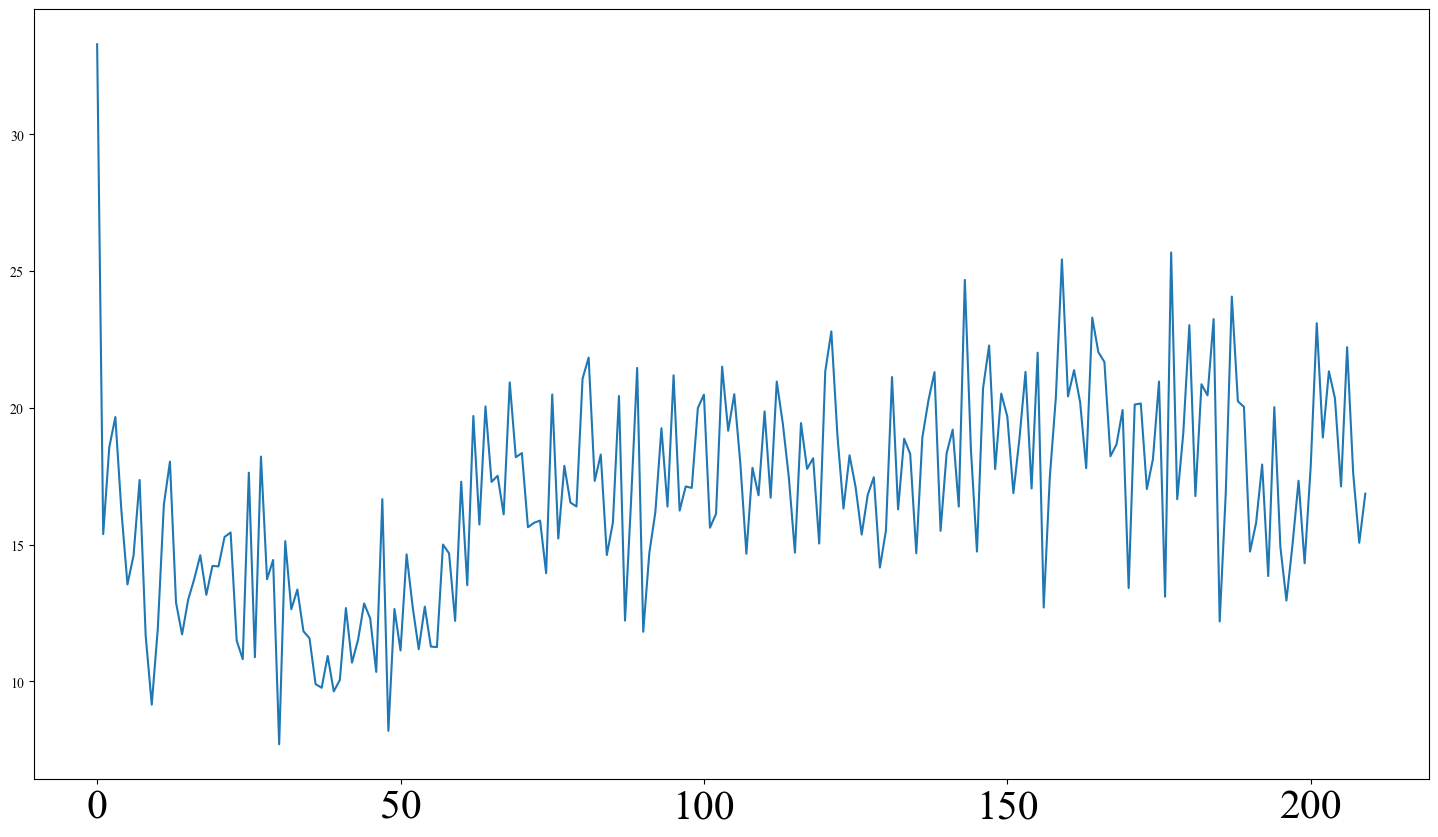

In [84]:
fig, ax = plt.subplots(figsize=(18, 10))
# ax.plot(np.array(Analytic_ws_online_perturb['Gen_D_KL_Layer_0']))
ax.plot(np.array(Analytic_ws_online_perturb['Recog_D_KL_Layer_0']))
plt.show()

In [85]:
# Analytic_ws_online.dtypes

In [86]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [87]:
np.save('Parameters_ws_online_perturb',parameters)

In [88]:
Analytic_ws_online_perturb.to_csv('Analytic_ws_online_perturb.csv', index = False)

In [45]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ct['Layer 0: H_Y'] = entropy(data_dist)
wake_ft['Layer 0: dist'] = data_dist_ft
wake_ft['Layer 0: H_Y'] = entropy_bernoulli(data_dist_ft)
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Ground Truth D_KL: 16.2358 H(Y): 6.8079
Layer 0 Generative D_KL: 0.401 H(Y): 7.0925
Layer 1 Recognition Distribution D_KL: 0.2821 H(Y): 6.2431 H(Y|X): 4.85 I_XY: 1.393
Layer 1 Generative  Distribution D_KL: 0.2521 H(Y): 7.0925 H(Y|X): 5.7301 I_XY: 1.3624
Layer 2 Recognition Distribution D_KL: 0.0867 H(Y): 4.9515 H(Y|X): 4.1308 I_XY: 0.8206
Layer 2 Generative  Distribution D_KL: 0.0903 H(Y): 6.2911 H(Y|X): 5.5073 I_XY: 0.7838
Layer 3 Recognition Distribution D_KL: 0.0151 H(Y): 3.8379 H(Y|X): 3.3532 I_XY: 0.4846
Layer 3 Generative  Distribution D_KL: 0.015 H(Y): 4.9436 H(Y|X): 4.4852 I_XY: 0.4584
Layer 4 Recognition Distribution D_KL: 0.0366 H(Y): 1.9516 H(Y|X): 1.7929 I_XY: 0.1587
Layer 4 Generative  Distribution D_KL: 0.0389 H(Y): 3.8803 H(Y|X): 3.6578 I_XY: 0.2225
Layer 4 Generative  Distribution D_KL: 0.0389 H(Y): 1.9928 H(Y|X): 1.9928 I_XY: 0.0


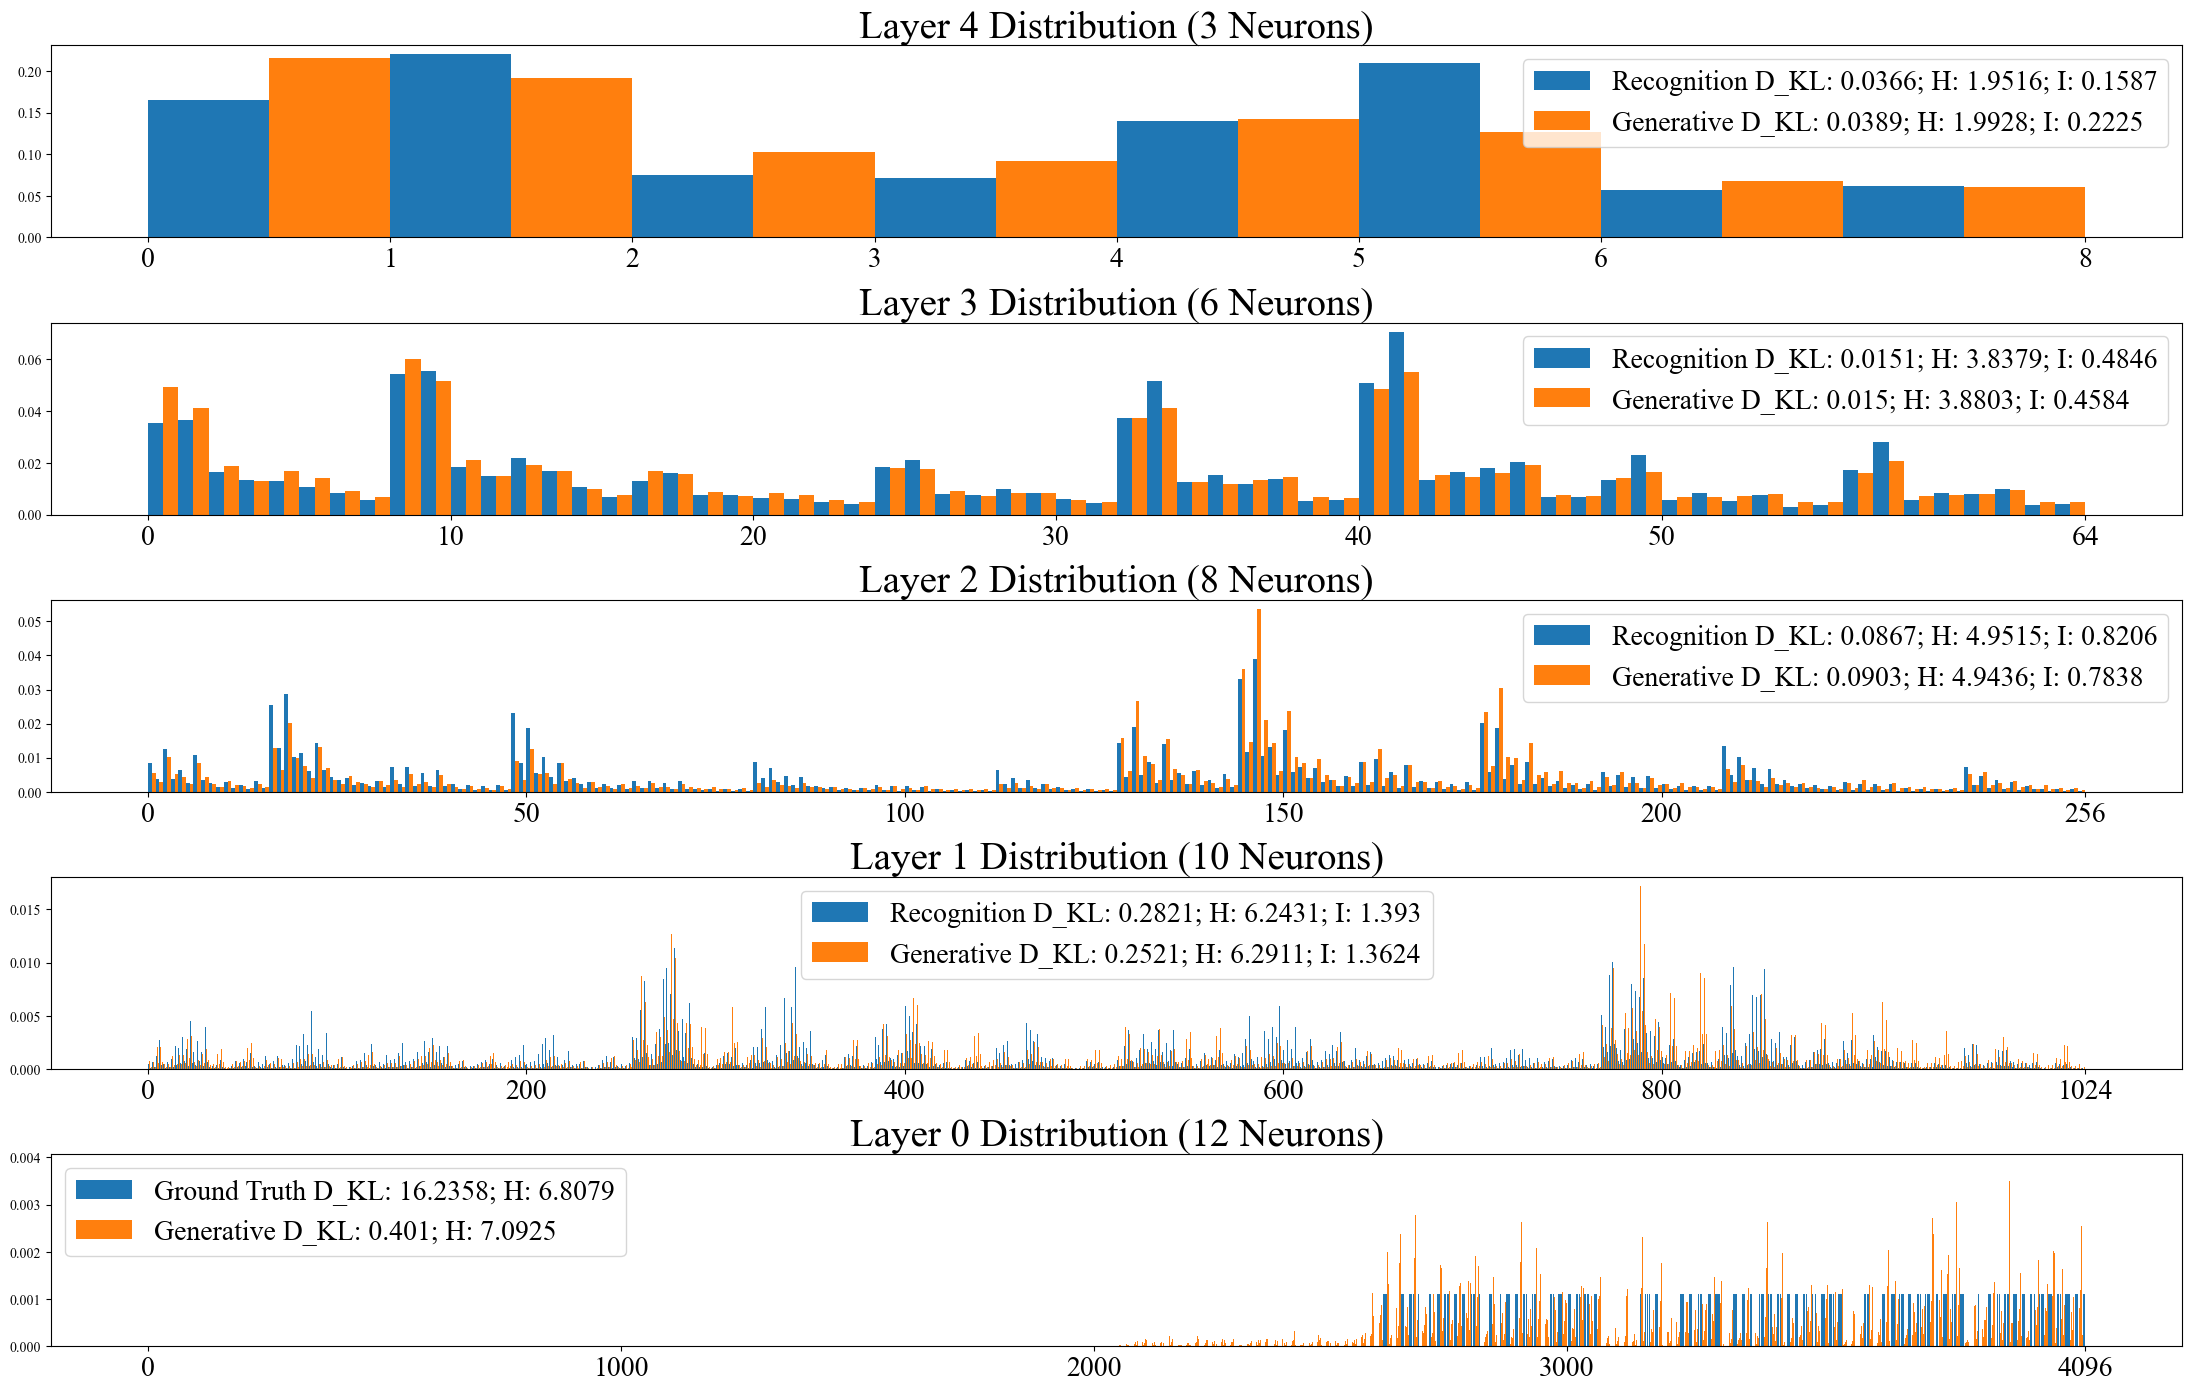

In [46]:
csfont = {'fontname':'Times New Roman'}
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rc('xtick', labelsize=20)

fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 14))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recognition D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(sleep_ct['Layer '+str(i)+': H_Y'].item(),4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Ground Truth D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Ground Truth D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Generative D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" Distribution ("+ str(n_dz[i].item())+" Neurons)",fontsize=28)
    ax_ct[n_layer-2-i].legend(fontsize=20)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    
H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
I_s = H_Y_s - H_YX_s
D_KL_s = KL_divergence(dist_w,dist_s).item()
print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
  "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
plt.tight_layout(pad=1)    
plt.show()

Layer 0 Data_dist D_KL: 16.2358 H(Y): 6.8079
Layer 0 Gen_dist D_KL: 0.401 H(Y): 7.0925
Layer 1 Recognition Distribution D_KL: 0.2821 H(Y): 6.2431 H(Y|X): 4.85 I_XY: 1.393
Layer 1 Generative  Distribution D_KL: 0.2521 H(Y): 7.0925 H(Y|X): 5.7301 I_XY: 1.3624
Layer 2 Recognition Distribution D_KL: 0.0867 H(Y): 4.9515 H(Y|X): 4.1308 I_XY: 0.8206
Layer 2 Generative  Distribution D_KL: 0.0903 H(Y): 6.2911 H(Y|X): 5.5073 I_XY: 0.7838
Layer 3 Recognition Distribution D_KL: 0.0151 H(Y): 3.8379 H(Y|X): 3.3532 I_XY: 0.4846
Layer 3 Generative  Distribution D_KL: 0.015 H(Y): 4.9436 H(Y|X): 4.4852 I_XY: 0.4584
Layer 4 Recognition Distribution D_KL: 0.0366 H(Y): 1.9516 H(Y|X): 1.7929 I_XY: 0.1587
Layer 4 Generative  Distribution D_KL: 0.0389 H(Y): 3.8803 H(Y|X): 3.6578 I_XY: 0.2225
Layer 4 Generative  Distribution D_KL: 0.0389 H(Y): 1.9928 H(Y|X): 1.9928 I_XY: 0.0


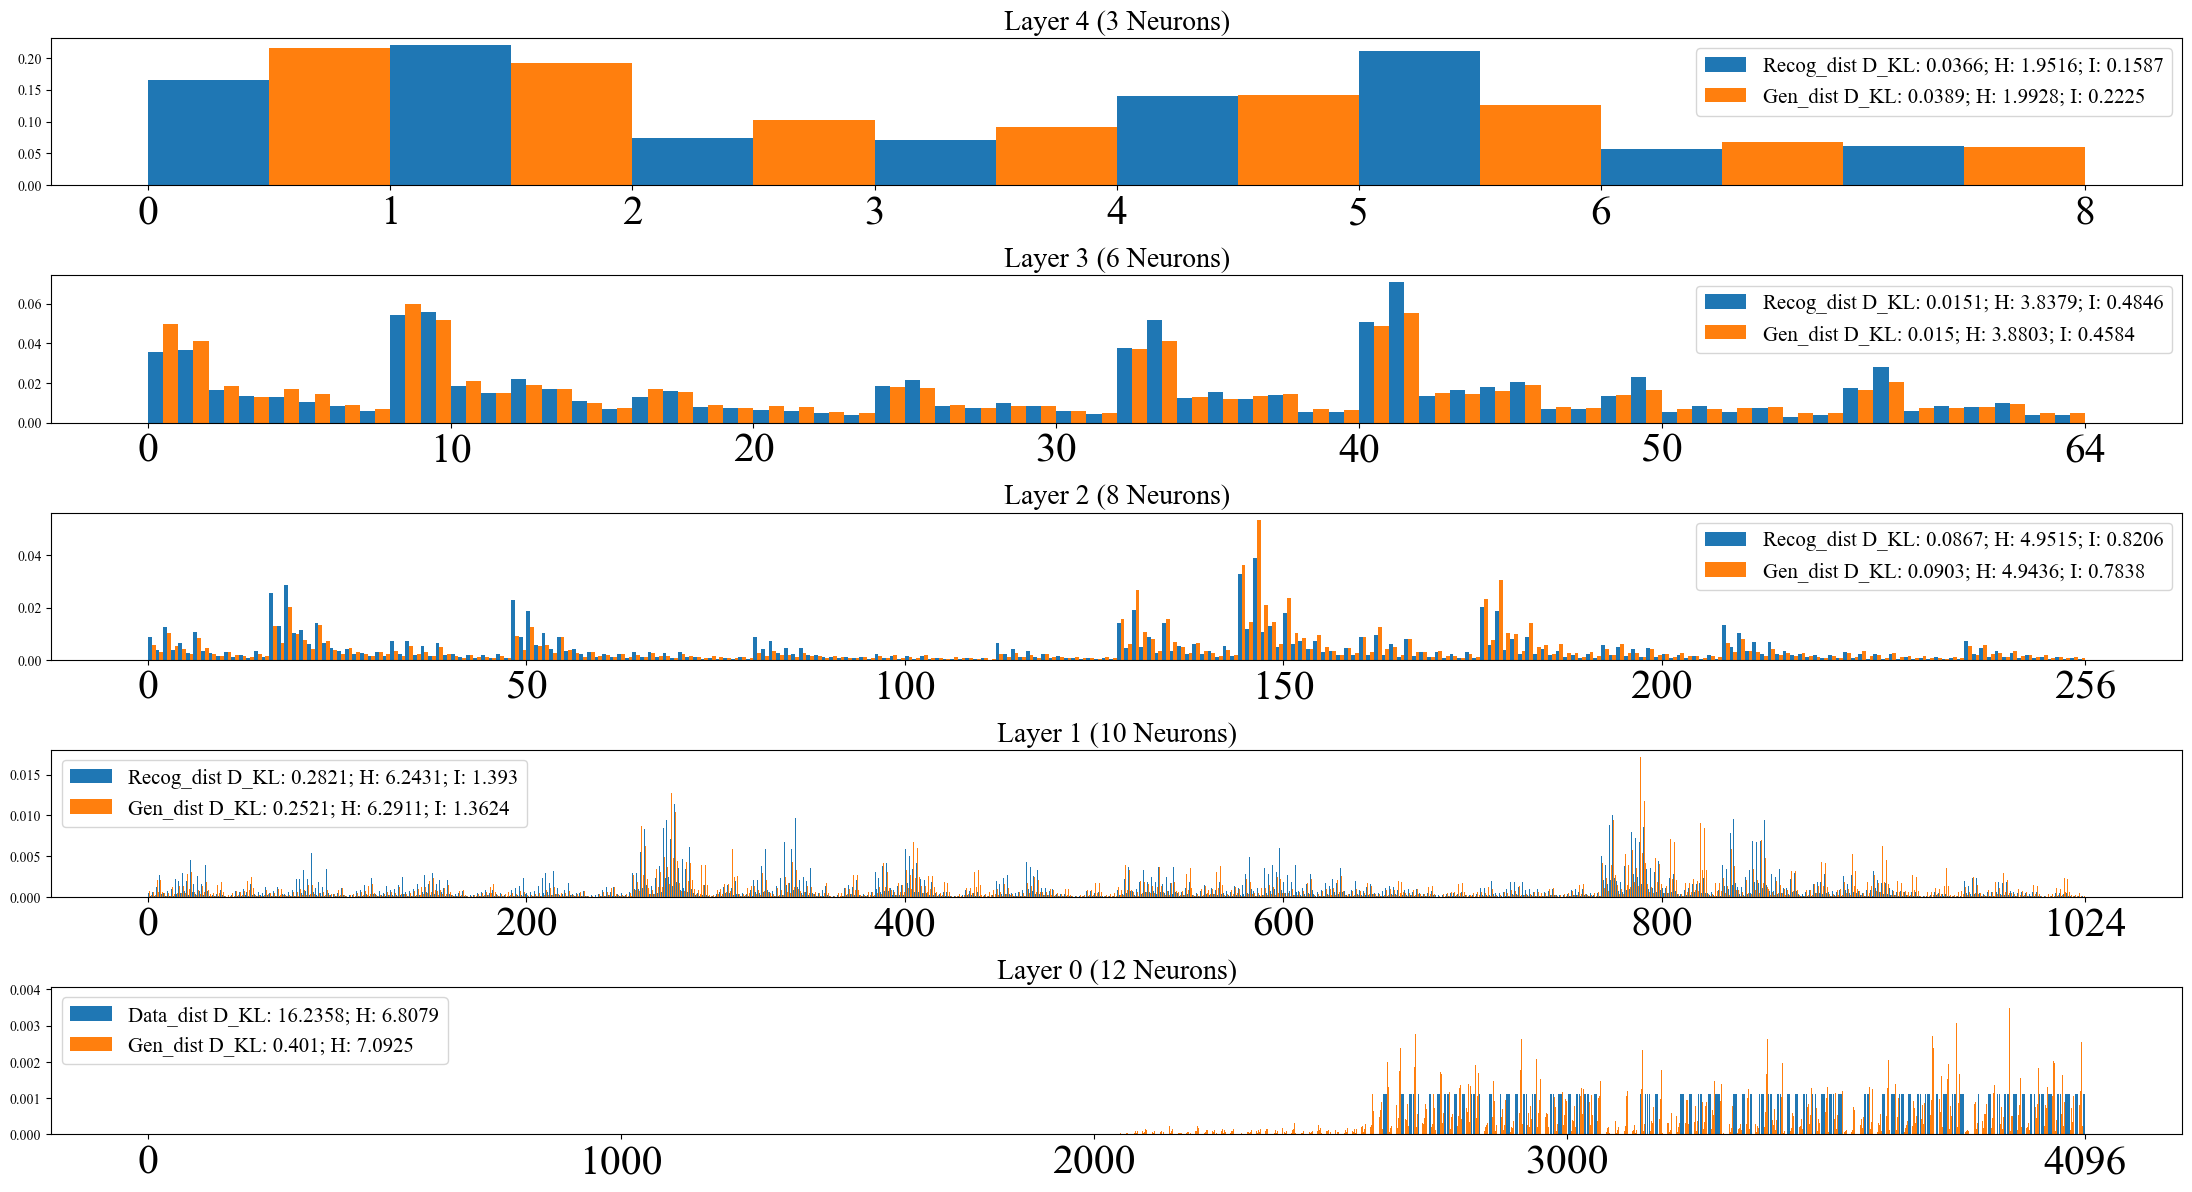

In [90]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(sleep_ct['Layer '+str(i)+': H_Y'].item(),4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    
H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
I_s = H_Y_s - H_YX_s
D_KL_s = KL_divergence(dist_w,dist_s).item()
print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
  "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
plt.tight_layout(pad=1)    
plt.show()

Layer 0 Ground Truth D_KL: 16.2358 H(Y): 6.8079
Layer 0 Generative D_KL: 0.401 H(Y): 7.0925
Layer 1 Recognition Distribution D_KL: 0.2821 H(Y): 6.2431 H(Y|X): 4.85 I_XY: 1.393
Layer 1 Generative  Distribution D_KL: 0.2521 H(Y): 7.0925 H(Y|X): 5.7301 I_XY: 1.3624
Layer 2 Recognition Distribution D_KL: 0.0867 H(Y): 4.9515 H(Y|X): 4.1308 I_XY: 0.8206
Layer 2 Generative  Distribution D_KL: 0.0903 H(Y): 6.2911 H(Y|X): 5.5073 I_XY: 0.7838
Layer 3 Recognition Distribution D_KL: 0.0151 H(Y): 3.8379 H(Y|X): 3.3532 I_XY: 0.4846
Layer 3 Generative  Distribution D_KL: 0.015 H(Y): 4.9436 H(Y|X): 4.4852 I_XY: 0.4584
Layer 4 Recognition Distribution D_KL: 0.0366 H(Y): 1.9516 H(Y|X): 1.7929 I_XY: 0.1587
Layer 4 Generative  Distribution D_KL: 0.0389 H(Y): 3.8803 H(Y|X): 3.6578 I_XY: 0.2225
Layer 4 Generative  Distribution D_KL: 0.0389 H(Y): 1.9928 H(Y|X): 1.9928 I_XY: 0.0


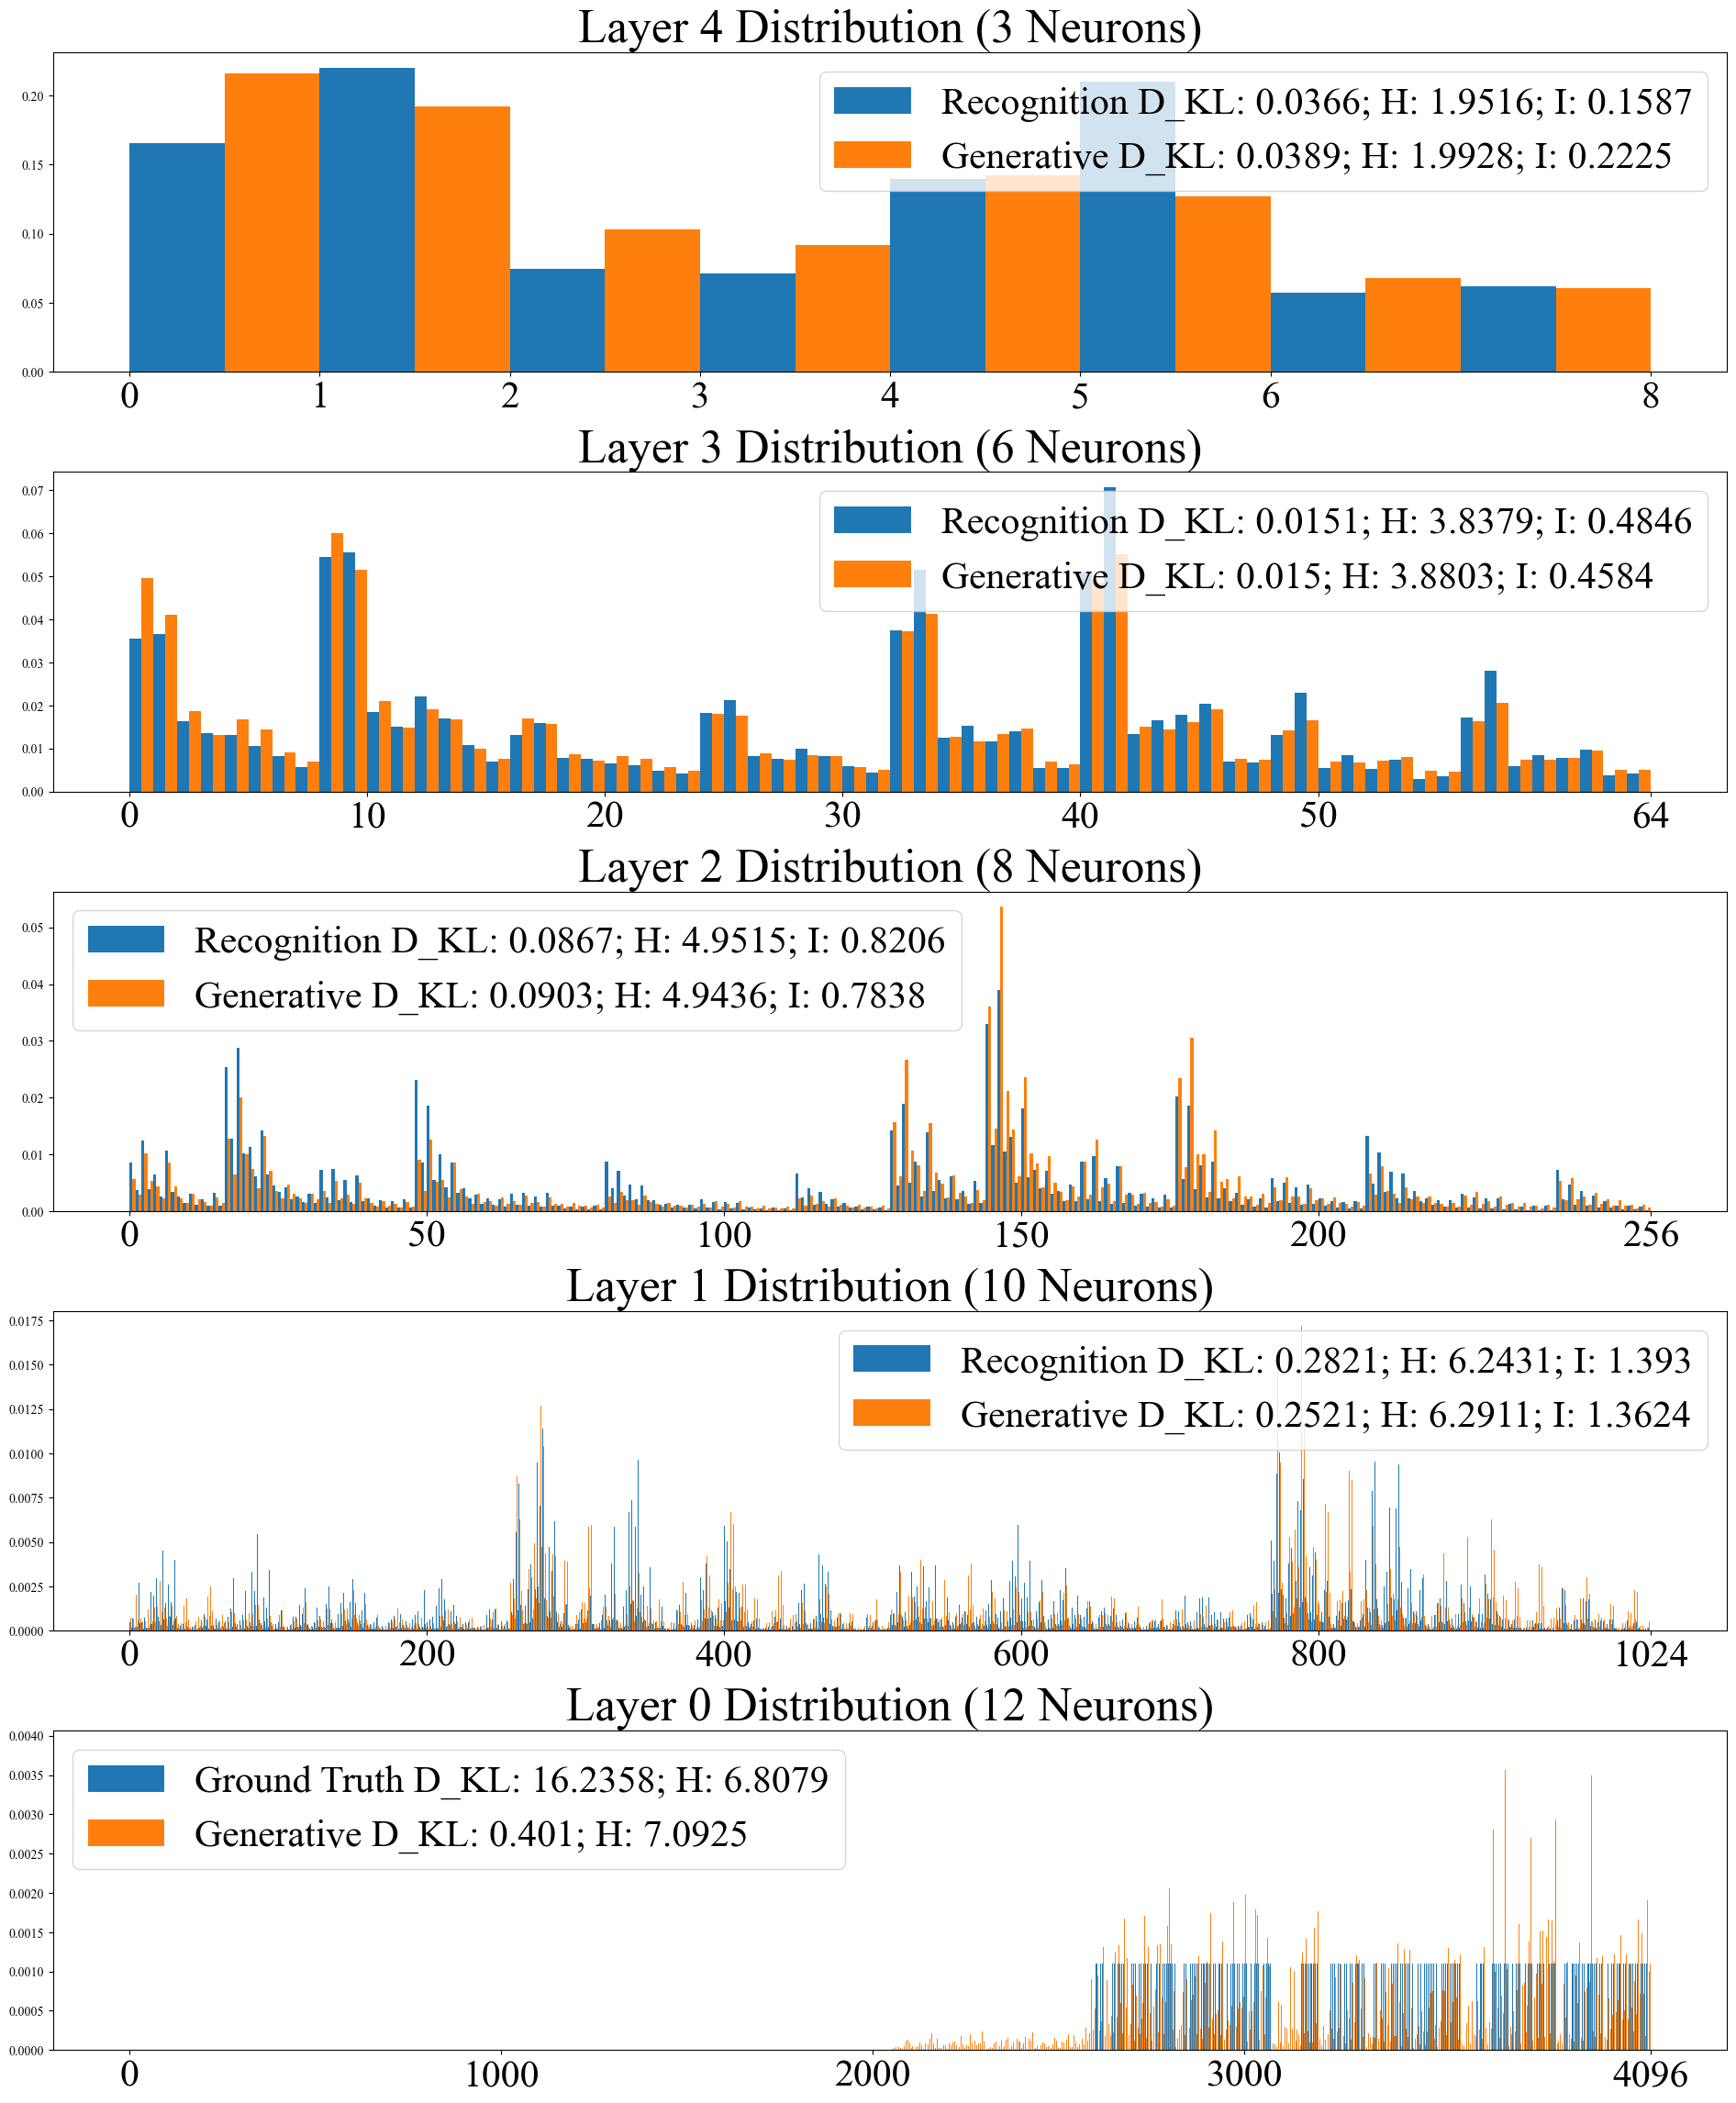

In [91]:
csfont = {'fontname':'Times New Roman'}
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rc('xtick', labelsize=30)
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(19, 23))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recognition D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(sleep_ct['Layer '+str(i)+': H_Y'].item(),4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Ground Truth D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Ground Truth D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Generative D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" Distribution ("+ str(n_dz[i].item())+" Neurons)",fontsize=37)
    ax_ct[n_layer-2-i].legend(fontsize=30)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    
H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
I_s = H_Y_s - H_YX_s
D_KL_s = KL_divergence(dist_w,dist_s).item()
print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
  "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))    
plt.tight_layout(pad=1)    
plt.show()

In [110]:
# fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
# fig_ct.suptitle("Layer-wise Factorial Distribution",fontsize=25)
# for i in range(n_layer-1):
#     dist_s = sleep_ft['Layer '+str(i)+': dist']
#     dist_w = wake_ft['Layer '+str(i)+': dist']
    
#     if i > 0:
#         H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
#         H_YX_w = wake_ft['Layer '+str(i)+': H_YX'].item()
#         I_w = H_Y_w - H_YX_w
#         D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        
#         print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
#           "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
           
#     H_Y_s = sleep_ft['Layer '+str(i)+': H_Y'].item()
#     H_YX_s = sleep_ft['Layer '+str(i)+': H_YX'].item()
#     I_s = H_Y_s - H_YX_s
#     D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
    
#     if i == 0:
#         D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
#         print("Layer "+str(i), "Data Distribution D_KL: "+str(np.around(D_KL_w,4)))
#         ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
#                            label = "Data Distribution D_KL: " + str(np.around(D_KL_w,4)))
#     else:
#         ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
#                            label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
#                                str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
    
#     ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
#                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
#                                str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
#     ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
#     ax_ct[n_layer-2-i].legend(fontsize=15)
    
#     print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
#           "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
# plt.tight_layout(pad=1)    
# plt.show()

### Plot Analytic

In [80]:
# Analytic_ws_online['Index'] = Analytic_ws_online.index

In [36]:
# for i in range(len(col_list)):
#     Analytic_ws_online.plot(x='Index',y=col_list[i],kind='line',legend=True)
# plt.close()

In [92]:
x = np.arange(len(Analytic_ws_online_perturb))

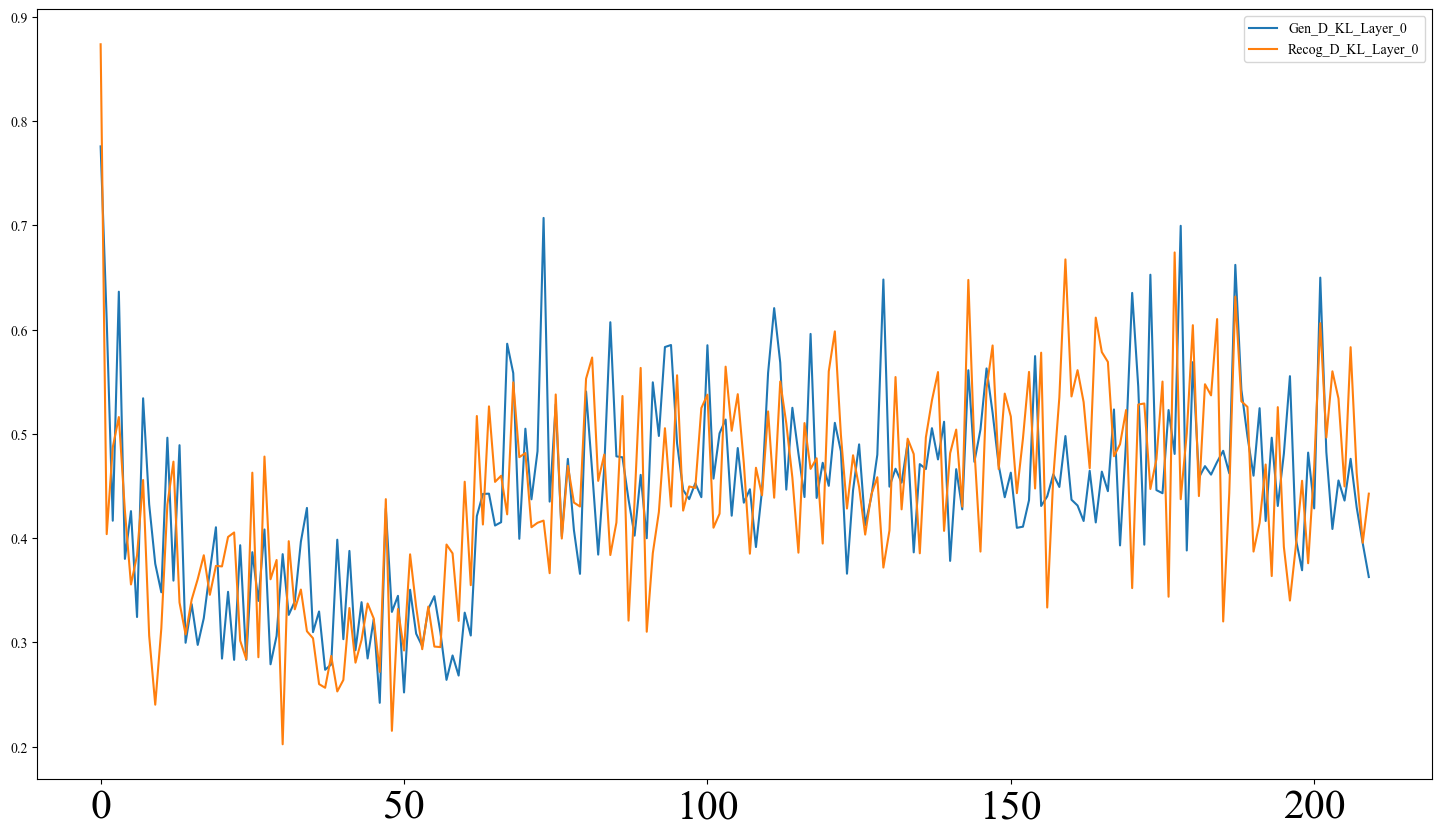

In [93]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_online_perturb['Gen_D_KL_Layer_'+str(0)]),label = 'Gen_D_KL_Layer_'+str(0))
ax.plot(x, np.array(Analytic_ws_online_perturb['Recog_D_KL_Layer_'+str(0)])/np.array(Analytic_ws_online_perturb['Recog_D_KL_Layer_'+str(0)]).mean()*np.array(Analytic_ws_online_perturb['Gen_D_KL_Layer_'+str(0)]).mean(),label = 'Recog_D_KL_Layer_'+str(0))
# ax.plot(x, np.array(Analytic_ws_online_perturb['Recog_D_KL_Layer_'+str(0)]),label = 'Recog_D_KL_Layer_'+str(0))
ax.legend()
plt.show()

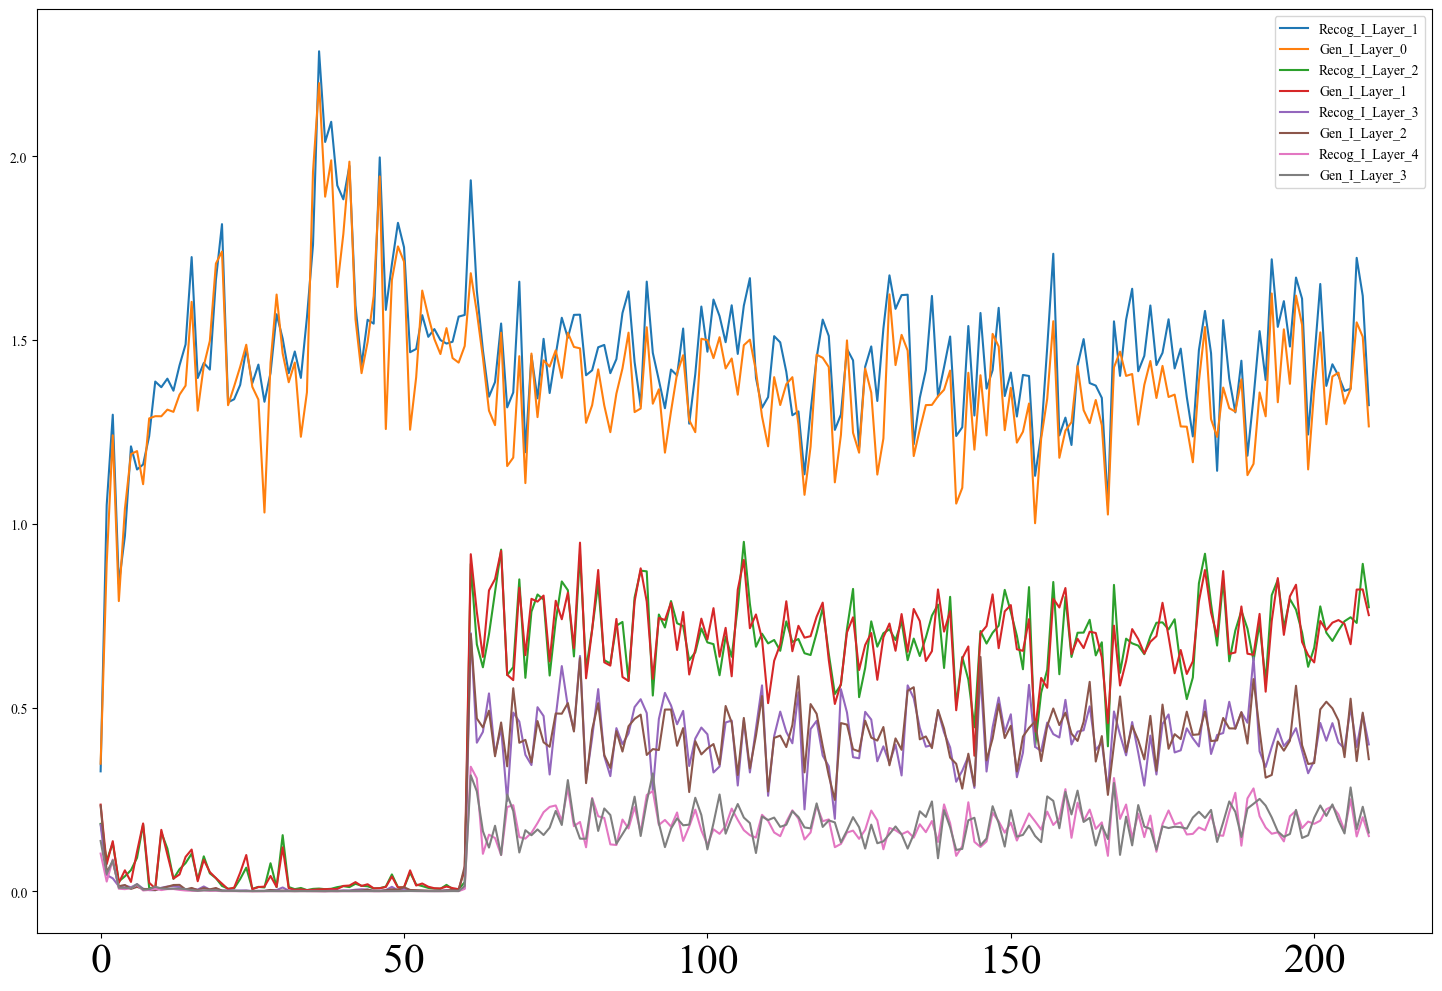

In [94]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(n_layer-2):
    ax.plot(x, np.array(Analytic_ws_online_perturb['Recog_I_Layer_'+str(i+1)]),label = 'Recog_I_Layer_'+str(i+1))
    ax.plot(x, np.array(Analytic_ws_online_perturb['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

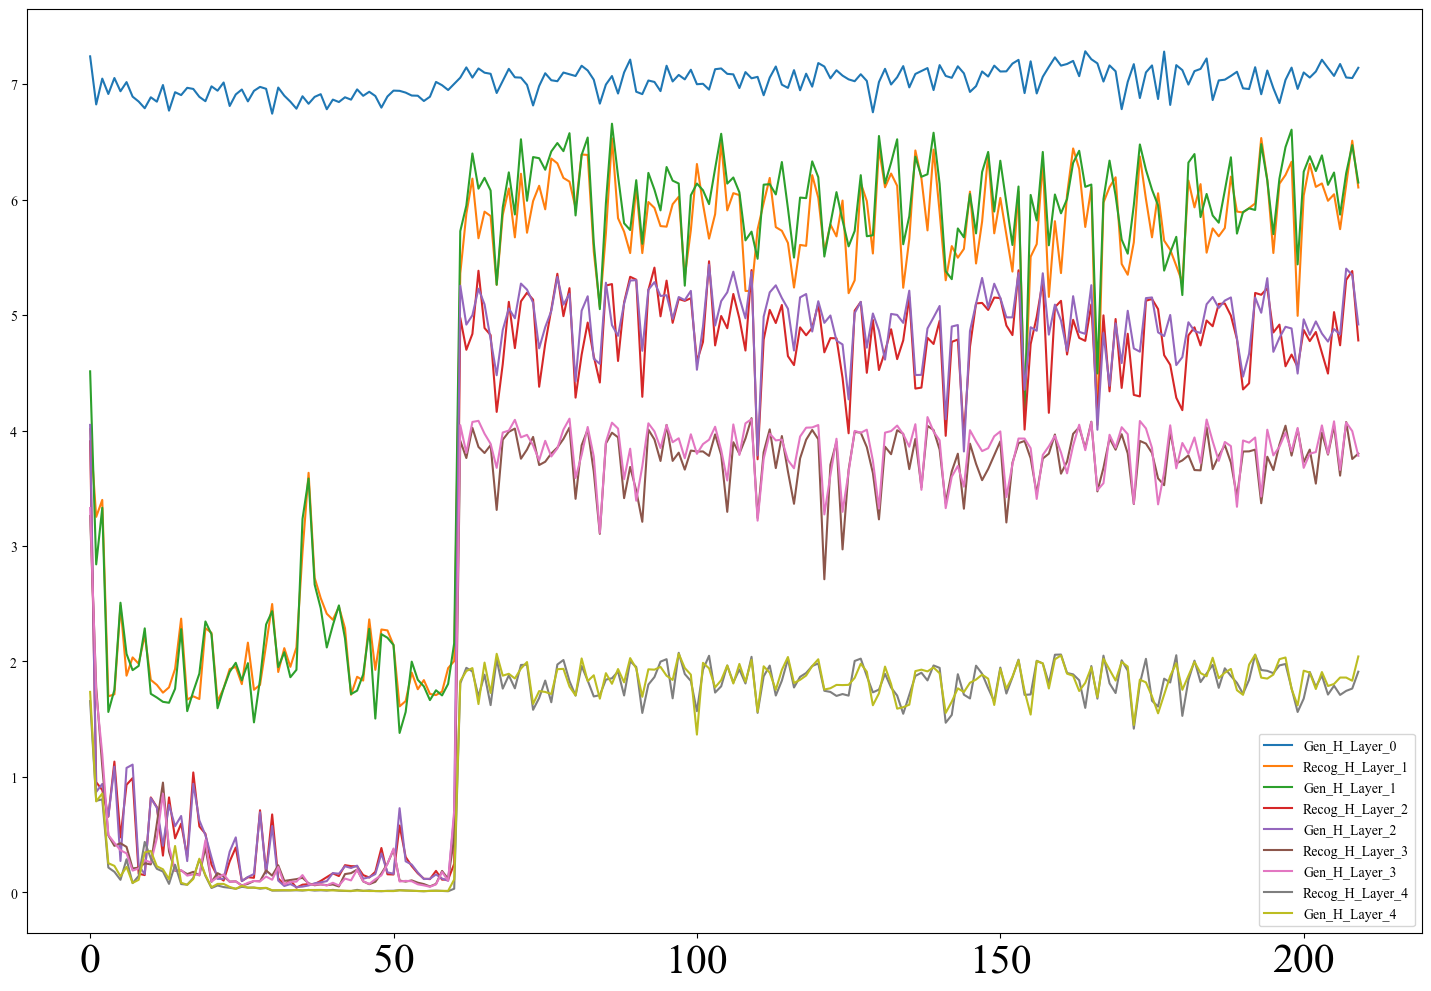

In [95]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(x, np.array(Analytic_ws_online_perturb['Gen_H_Layer_'+str(0)]),label = 'Gen_H_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online_perturb['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online_perturb['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

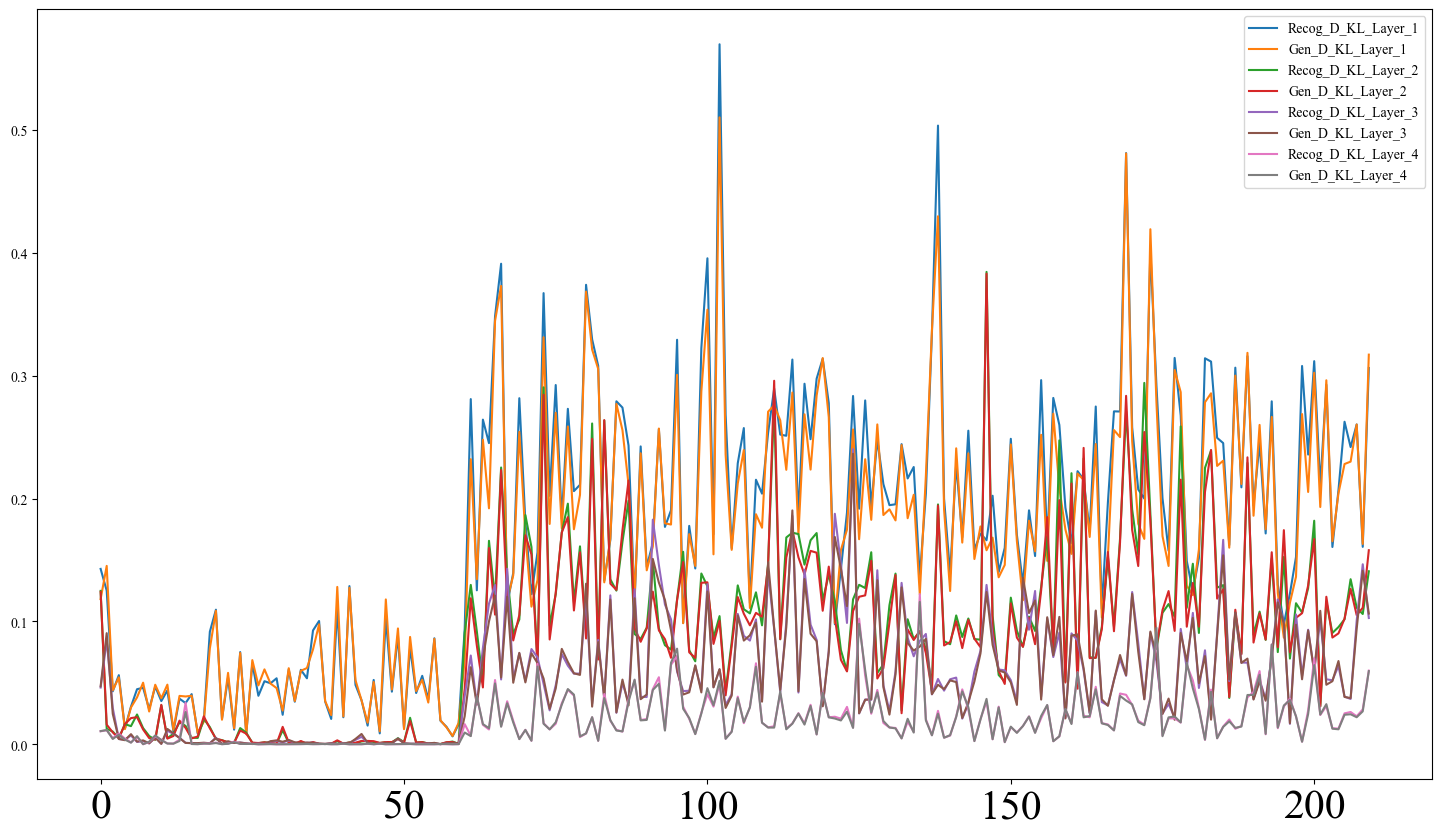

In [96]:
fig, ax = plt.subplots(figsize=(18, 10))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online_perturb['Recog_D_KL_Layer_'+str(i)]),label = 'Recog_D_KL_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online_perturb['Gen_D_KL_Layer_'+str(i)]),label = 'Gen_D_KL_Layer_'+str(i))
ax.legend()
plt.show()

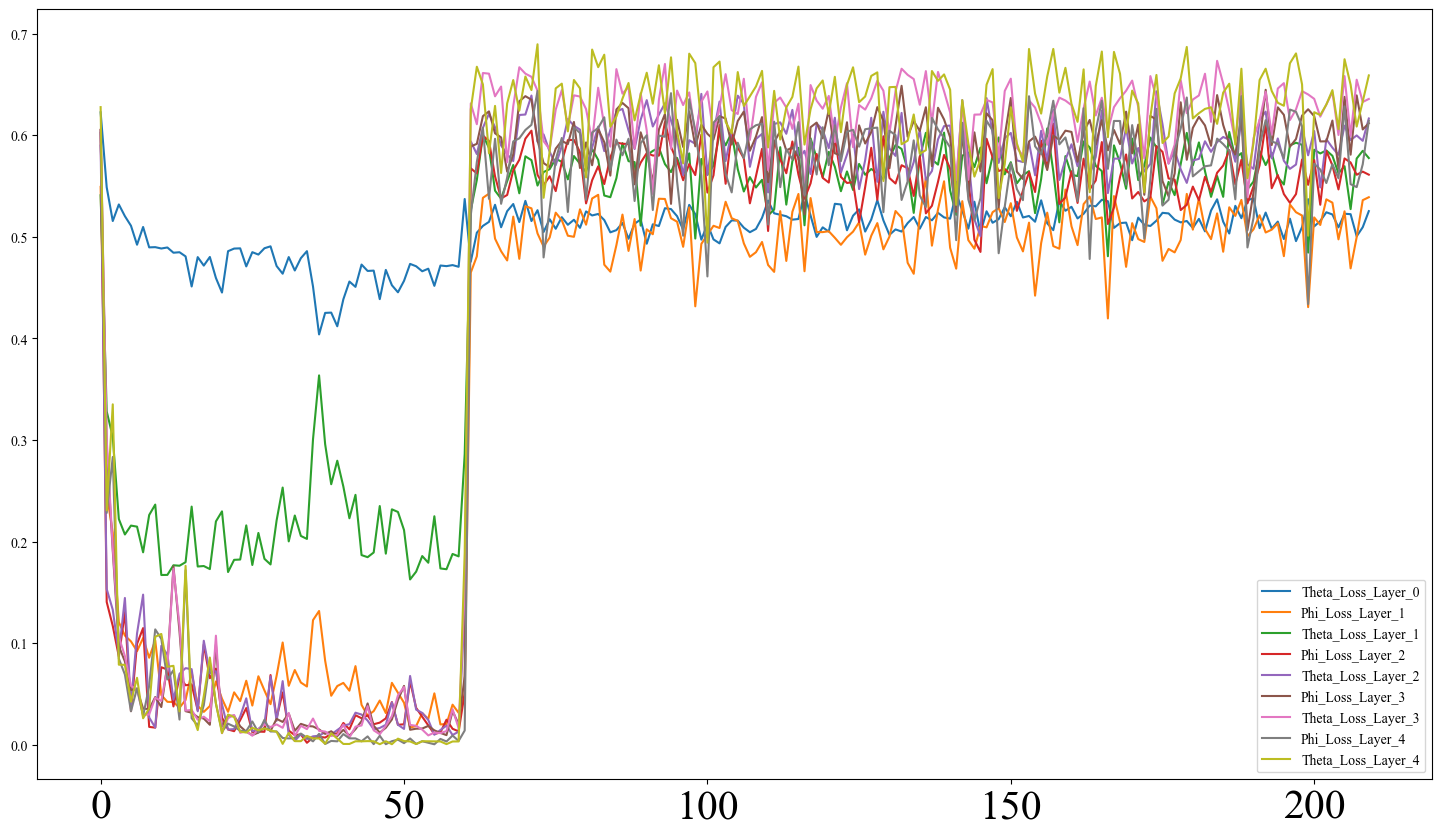

In [97]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_online_perturb['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online_perturb['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online_perturb['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()